This example is based on - **`Learn Generative AI with Pytorch by Mark Liu`**, Chapter 3, Generative Adversial Networks: Shape and Number Generation

In [1]:
import torch

torch.manual_seed(0)

observations = 2048  # Number of observations

# Create a tensor with 2,048 rows and 2 columns
train_data = torch.zeros((observations, 2))

# Generate values of x between 0 and 50
train_data[:, 0] = 50 * torch.rand(observations)

# Generate values of y based on the relation y = 1.08^x
train_data[:, 1] = 1.08 ** train_data[:, 0]


### **Exercise 3.1**
Modify listing 3.1 so that the relation between x and y is `y = sin(x)` by using the `torch.sin()` function. Set the value of x between –5 and 5 by using this line of code: `train_data[:,0]=10*(torch.rand(observations)-0.5)`.

In [2]:
train_data_sin =  train_data.clone() # separate memory clone

# Create x between -5 and 5
train_data_sin[:, 0] = 10 * (torch.rand(observations) - 0.5)

# create the y = sin(x)
train_data_sin[:, 1] = torch.sin(train_data_sin[:, 0])

## Plotting x and y

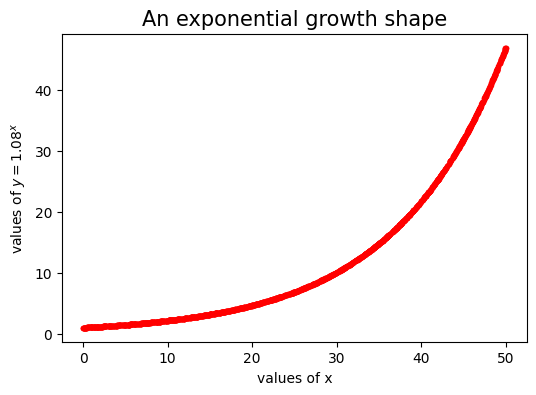

In [3]:
import matplotlib.pyplot as plt

fig = plt.figure(dpi=100, figsize=(6,4))
plt.plot(train_data[:, 0], train_data[:, 1], ".", c="r")
plt.xlabel("values of x",fontsize=10)
plt.ylabel("values of $y=1.08^x$",fontsize=10)
plt.title("An exponential growth shape",fontsize=15)
plt.show()

### **Exercise 3.2**
Modify listing 3.2 to plot the relation between x and `y = sin(x)` based on your changes in <em>`exercise 3.1`</em>. Make sure you change the y-axis label and the title in the plot to reflect the
changes you made

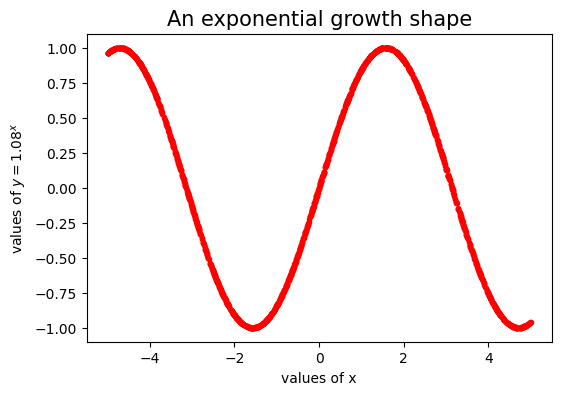

In [4]:
import matplotlib.pyplot as plt

fig = plt.figure(dpi=100, figsize=(6,4))
plt.plot(train_data_sin[:, 0], train_data_sin[:, 1], ".", c="r")
plt.xlabel("values of x",fontsize=10)
plt.ylabel("values of $y=1.08^x$",fontsize=10)
plt.title("An exponential growth shape",fontsize=15)
plt.show()

## Prepare Data for Training

In [5]:
from torch.utils.data import DataLoader

batch_size=16

train_loader=DataLoader(
 train_data,
 batch_size=batch_size,
 shuffle=True)

In [6]:
# You can access a batch of data by using the next() and iter() methods, like so

batch0=next(iter(train_loader))
print(batch0)

tensor([[ 0.3502,  1.0273],
        [34.6425, 14.3841],
        [33.0733, 12.7477],
        [37.8458, 18.4056],
        [37.8474, 18.4078],
        [33.5004, 13.1738],
        [ 3.0980,  1.2692],
        [32.6420, 12.3316],
        [30.5034, 10.4602],
        [42.0226, 25.3837],
        [39.2565, 20.5164],
        [ 4.6602,  1.4314],
        [16.9610,  3.6889],
        [42.8959, 27.1484],
        [18.9863,  4.3112],
        [46.4489, 35.6859]])


## Creating GAN

### **The Descriminator**

Descriminator is a binary classifier here, as it will classify the output of generator as real or fake.

In [7]:
import torch.nn as nn

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [8]:
# The Dessriminator

D = nn.Sequential(
    nn.Linear(2,256), # each data point input is of shape (2,) - (x,y)
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256,128),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(128,64),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(64,1),
    nn.Sigmoid()).to(device)

In [9]:
# The Generator Network
G = nn.Sequential(
    nn.Linear(2,16),
    nn.ReLU(),
    nn.Linear(16,32),
    nn.ReLU(),
    nn.Linear(32,2)).to(device) # generates the output with same dimension as input

## Configuration

In [10]:
loss_fn=nn.BCELoss()
lr=0.0005
optimD=torch.optim.Adam(D.parameters(),lr=lr)
optimG=torch.optim.Adam(G.parameters(),lr=lr)

In [11]:
mse=nn.MSELoss()

def performance(fake_samples):
 real=1.08**fake_samples[:,0]
 mseloss=mse(fake_samples[:,1],real)
 return mseloss

In [12]:
# Define Early Stopping Function

class EarlyStop:
  def __init__(self, patience=1000):
    self.patience = patience
    self.steps = 0
    self.min_gdif = float('inf')

  def stop(self, gdif):
    if gdif < self.min_gdif:
      self.min_gdif = gdif
      self.steps = 0
    elif gdif >= self.min_gdif:
      self.steps += 1
    if self.steps >= self.patience:
      return True
    else:
      return False

stopper=EarlyStop()

## **Training**

In [13]:
real_labels=torch.ones((batch_size,1))
real_labels=real_labels.to(device)

fake_labels=torch.zeros((batch_size,1))
fake_labels=fake_labels.to(device)

In [14]:
def train_D_on_real(real_samples):
 real_samples=real_samples.to(device)
 optimD.zero_grad()
 out_D=D(real_samples)
 loss_D=loss_fn(out_D,real_labels)
 loss_D.backward()
 optimD.step()
 return loss_D

In [15]:
def train_D_on_fake():
 noise=torch.randn((batch_size,2))
 noise=noise.to(device)
 fake_samples=G(noise)
 optimD.zero_grad()
 out_D=D(fake_samples)
 loss_D=loss_fn(out_D,fake_labels)
 loss_D.backward()
 optimD.step()
 return loss_D

In [16]:
def train_G():
 noise=torch.randn((batch_size,2))
 noise=noise.to(device)
 optimG.zero_grad()
 fake_samples=G(noise)
 out_G=D(fake_samples)
 loss_G=loss_fn(out_G,real_labels)
 loss_G.backward()
 optimG.step()
 return loss_G, fake_samples

In [17]:
import os
os.makedirs("files", exist_ok=True)
def test_epoch(epoch,gloss,dloss,n,fake_samples):
 if epoch==0 or (epoch+1)%25==0:
  g=gloss.item()/n
  d=dloss.item()/n
  print(f"at epoch {epoch+1}, G loss: {g}, D loss {d}")
  fake=fake_samples.detach().cpu().numpy()
  plt.figure(dpi=100)
  plt.plot(fake[:,0],fake[:,1],"*",c="g",
  label="generated samples")
  plt.plot(train_data[:,0],train_data[:,1],".",c="r",
  alpha=0.1,label="real samples")
  plt.title(f"epoch {epoch+1}")
  plt.xlim(0,50)
  plt.ylim(0,50)
  plt.legend()
  plt.savefig(f"files/p{epoch+1}.png")
  plt.show()

In [18]:
for epoch in range(10000):
  gloss=0
  dloss=0
  for n, real_samples in enumerate(train_loader):
    loss_D=train_D_on_real(real_samples)
    dloss+=loss_D
    loss_D=train_D_on_fake()
    dloss+=loss_D
    loss_G,fake_samples=train_G()
    gloss+=loss_G
  test_epoch(epoch,gloss,dloss,n,fake_samples)
  gdif=performance(fake_samples).item()
  if stopper.stop(gdif)==True:
    break

Output hidden; open in https://colab.research.google.com to view.

In [21]:
# Saving GAN
import os
os.makedirs("files", exist_ok=True)
scripted = torch.jit.script(G)
scripted.save('files/exponential.pt')


In [23]:
new_G=torch.jit.load('/content/files/exponential.pt',
 map_location=device)
new_G.eval()

RecursiveScriptModule(
  original_name=Sequential
  (0): RecursiveScriptModule(original_name=Linear)
  (1): RecursiveScriptModule(original_name=ReLU)
  (2): RecursiveScriptModule(original_name=Linear)
  (3): RecursiveScriptModule(original_name=ReLU)
  (4): RecursiveScriptModule(original_name=Linear)
)

In [24]:
noise=torch.randn((batch_size,2)).to(device)
new_data=new_G(noise)

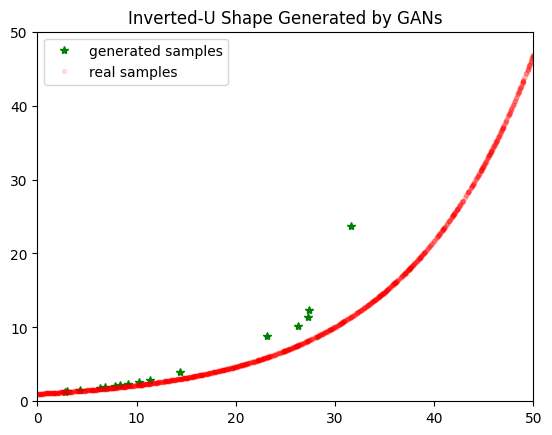

In [25]:
fig=plt.figure(dpi=100)
plt.plot(new_data.detach().cpu().numpy()[:,0],
 new_data.detach().cpu().numpy()[:,1],"*",c="g",
 label="generated samples")
plt.plot(train_data[:,0],train_data[:,1],".",c="r",
 alpha=0.1,label="real samples")
plt.title("Inverted-U Shape Generated by GANs")
plt.xlim(0,50)
plt.ylim(0,50)
plt.legend()
plt.show()